# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/dsoaws/amazon-reviews-pds/readme.html

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

In [2]:
!aws s3 cp 's3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [3]:
import csv

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df.shape

(102084, 15)

In [4]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

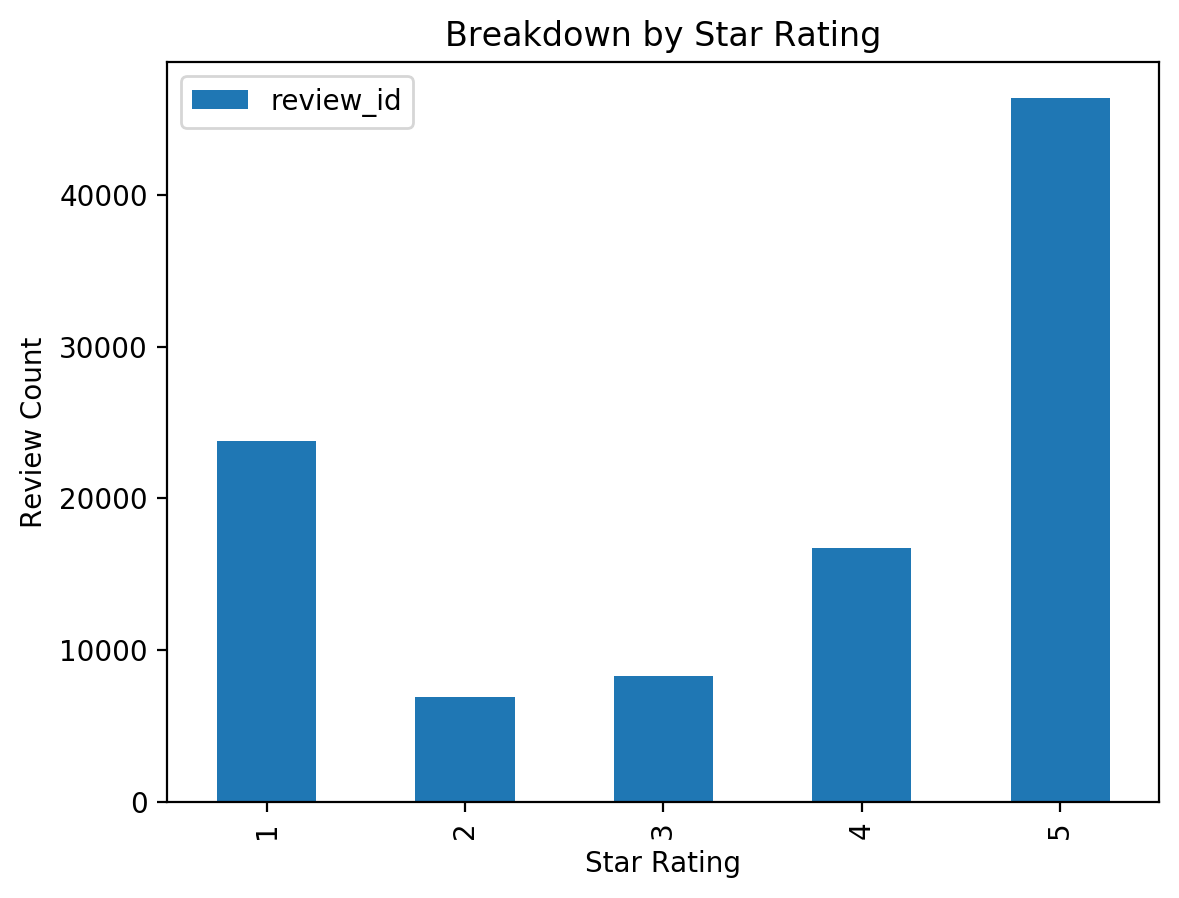

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

In [6]:
print("Shape of dataframe before splitting {}".format(df.shape))

Shape of dataframe before splitting (102084, 15)


In [7]:
# Balance the dataset down to the minority class
df_grouped_by = df.groupby(["star_rating"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (34450, 15)


Text(0, 0.5, 'Review Count')

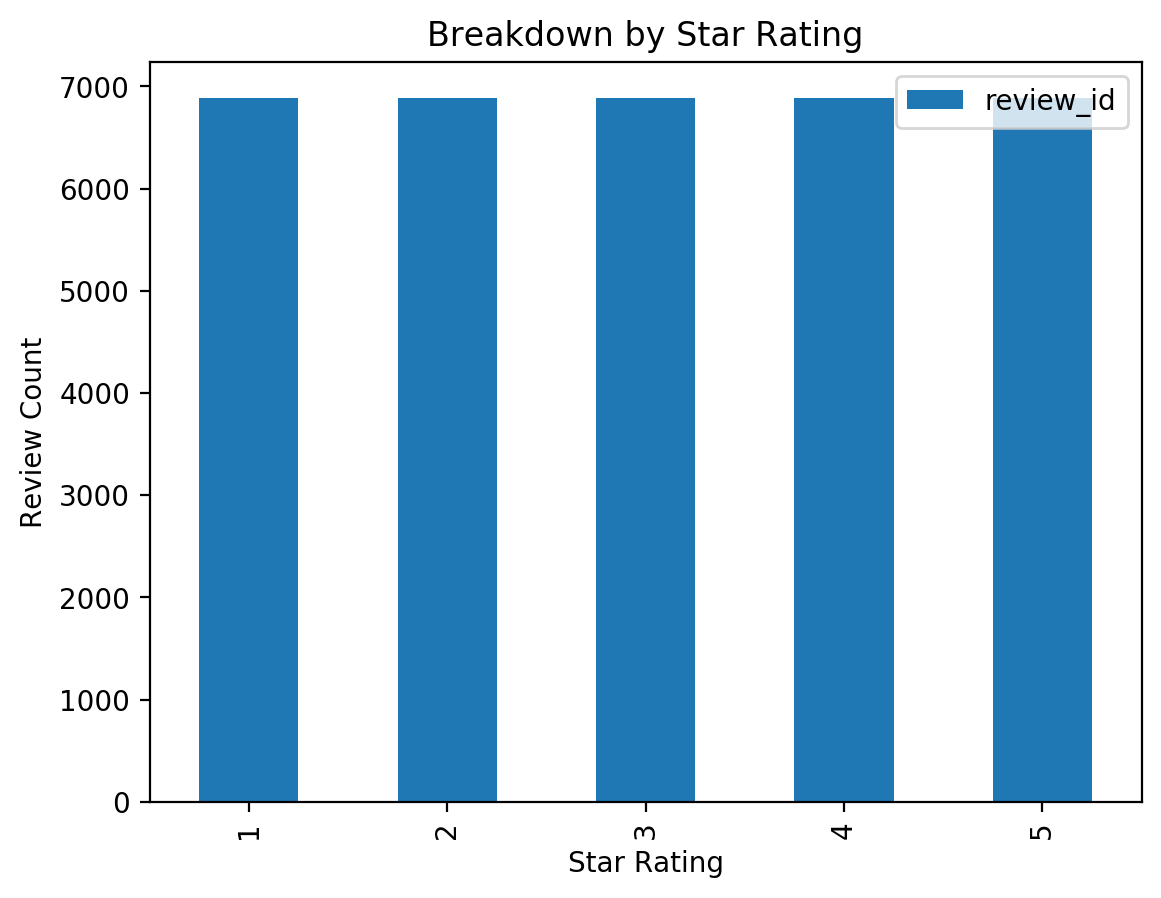

In [8]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [9]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,26516780,R37X2YBEYMYVDM,B00FGDDTSQ,672725528,Norton 360 1 User 3 Licenses,Digital_Software,1,0,0,N,Y,Poor Technical Service and Flawed Downloading,Downloading the 2014 version was a big mistake...,2014-09-15
1,US,20409617,R1N3F3TT79HFYB,B00E7XA7KY,189774198,Quickbooks Pro,Digital_Software,1,1,1,N,Y,Legal Extortion?,I have just been extorted by Key and Quickbook...,2014-07-03
2,US,51322371,R3ARWXZK921DLU,B005O24HZ8,321021950,Adobe Photoshop Elements and Premiere Elements...,Digital_Software,1,7,12,N,N,POS STAY AWAY ! ! !,"I bought this when it was on sale . I thought,...",2012-05-24
3,US,17342485,R3FZD1K5O6CLEY,B00B766VZE,665013666,Microsoft Office 365 University 4 Year | PC or...,Digital_Software,1,1,2,N,Y,garbage,"was verified instantly, then could not redeem,...",2014-05-11
4,US,2599829,RN5IXHLBTHCWX,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],Digital_Software,1,0,0,N,Y,One Star,not good,2014-08-06


## Reduce dataset size
This part has been added to make the later notebooks faster

In [11]:
df_balanced.shape

(34450, 15)

In [12]:
df_balanced = df_balanced.sample(n=1000, replace=False, random_state=2024)

# Split the Data into Train, Validation, and Test Sets

In [13]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

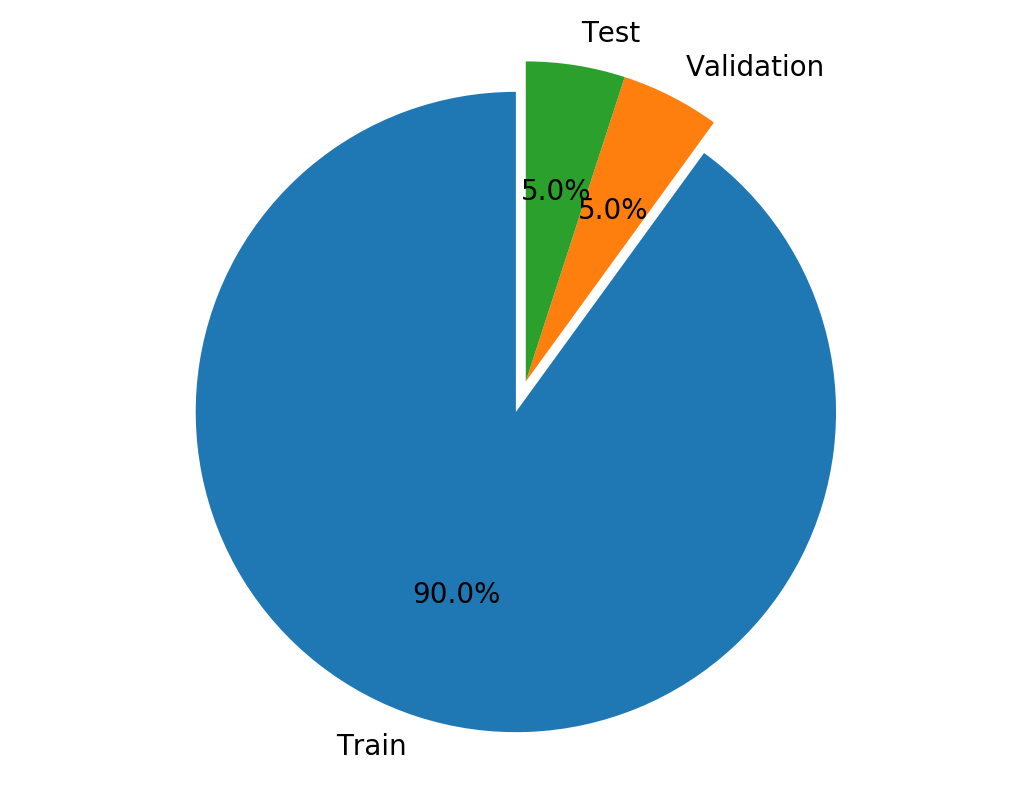

In [14]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [15]:
df_train.shape

(900, 15)

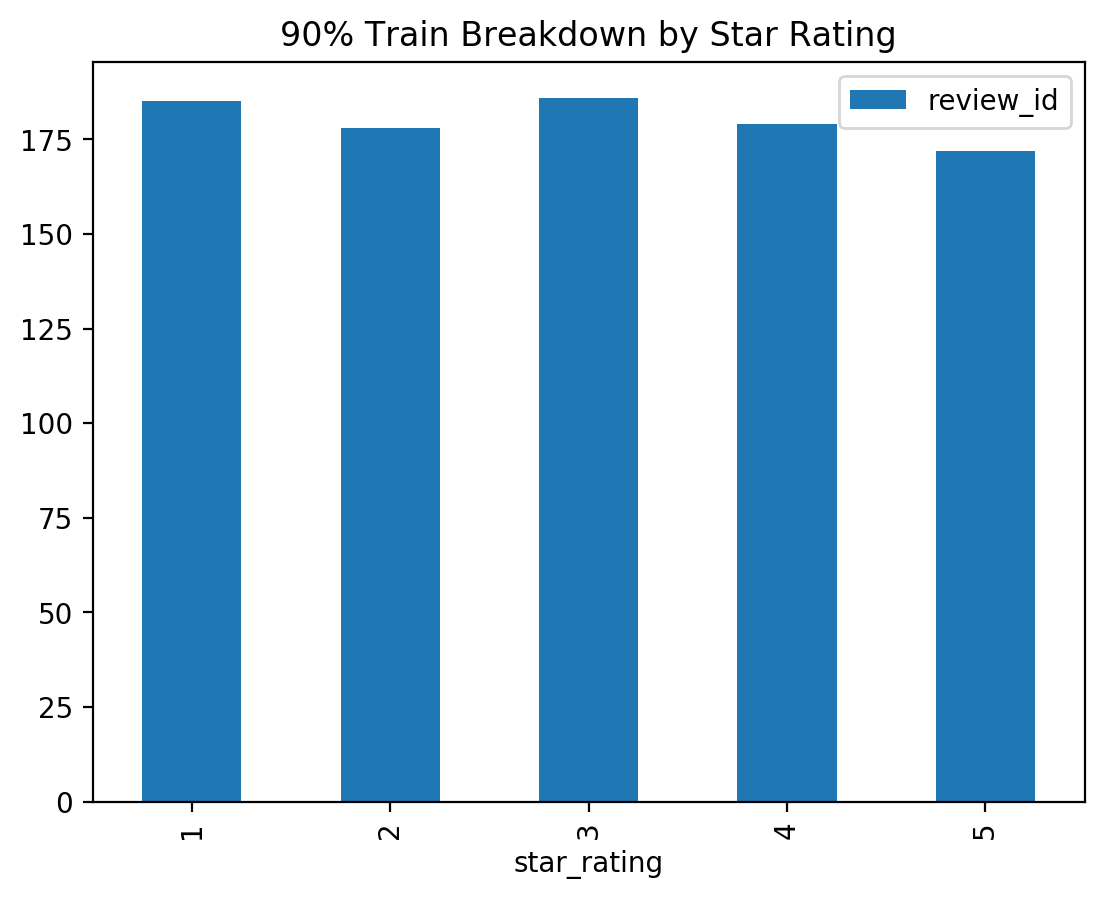

In [16]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [17]:
df_validation.shape

(50, 15)

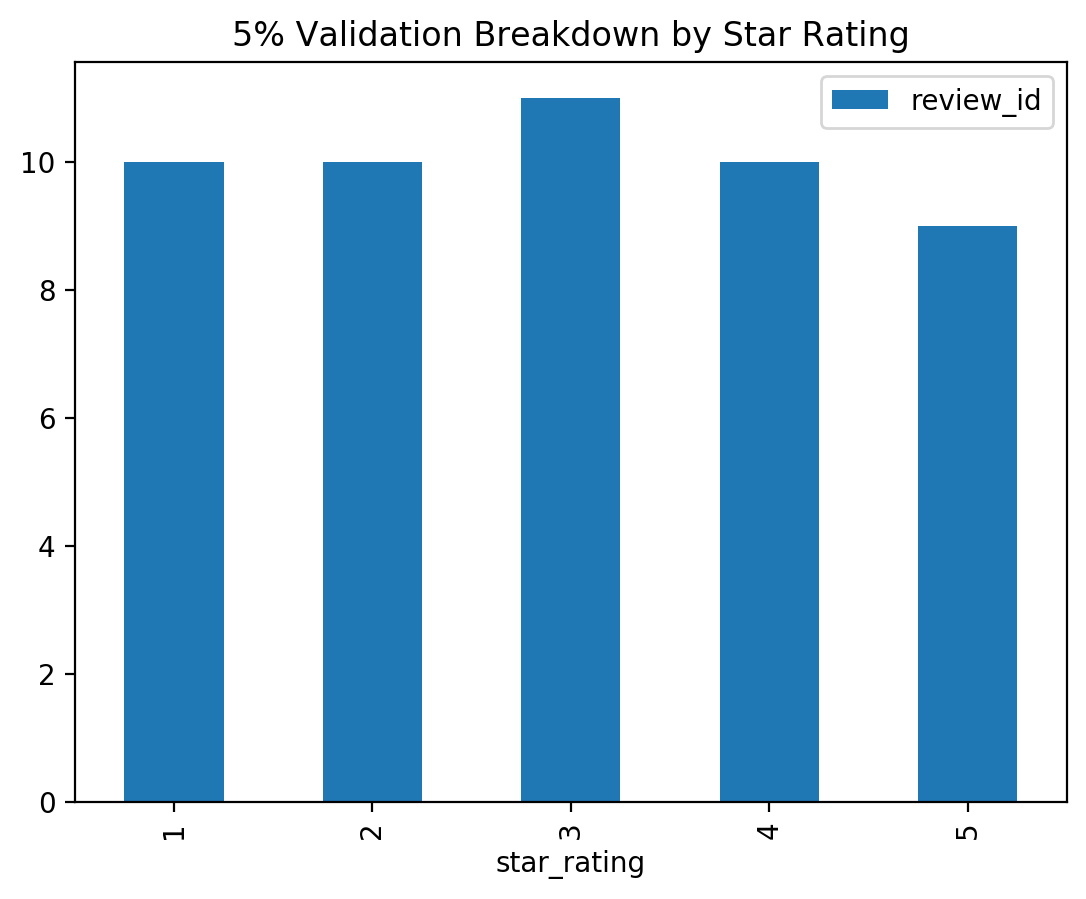

In [18]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [19]:
df_test.shape

(50, 15)

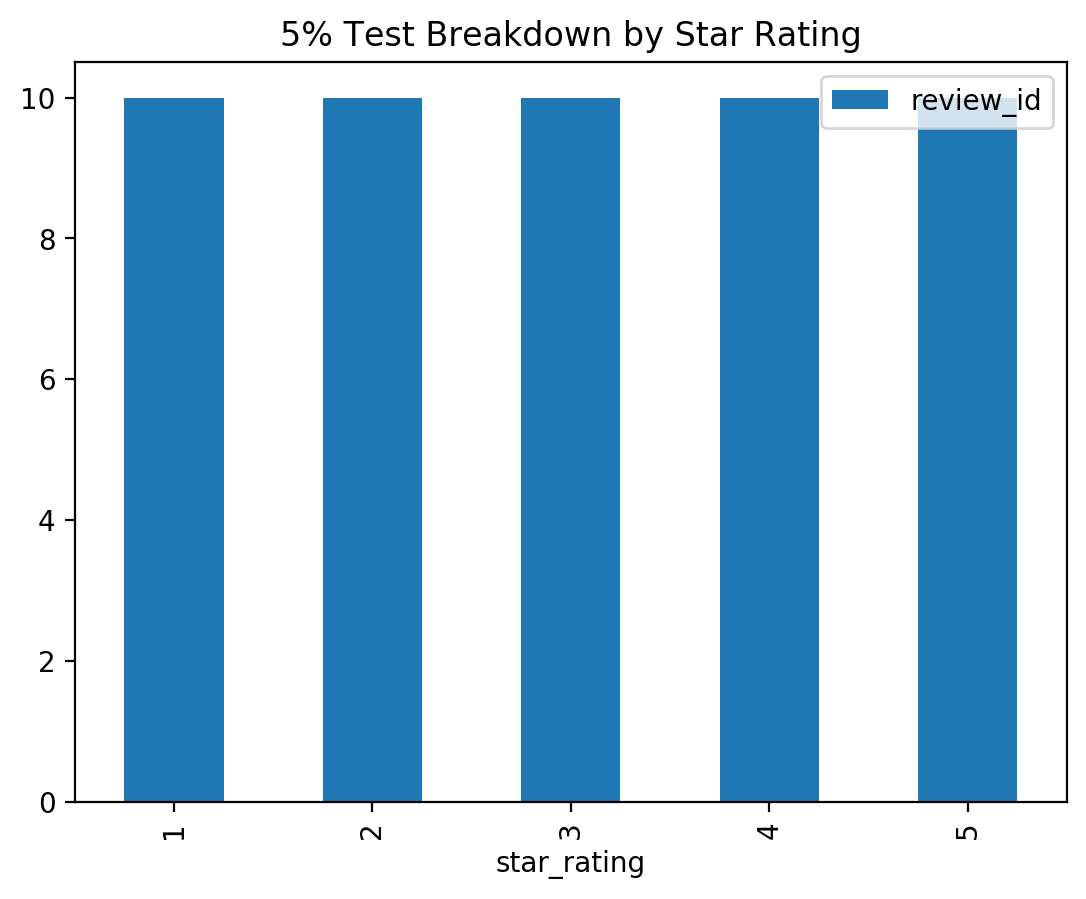

In [20]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [21]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(900, 2)

In [22]:
df_train.head(5)

,star_rating,review_body
17017,3,Works great for the Federal. But I had to mail...
30432,5,The bit defender antivirus plus is great!
10827,2,"Basically, I paid for the ability to download ..."
16497,3,Longtime user. Would give 5 stars to the 2002-...
11191,2,"Quicken for Mac 2015 is a nice idea, but it's ..."


# Write a CSV With No Header for Comprehend 

In [23]:
comprehend_train_path = "./amazon_reviews_us_Digital_Software_v1_00_comprehend.csv"
df_train.to_csv(comprehend_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [24]:
train_s3_prefix = "data"
comprehend_train_s3_uri = sess.upload_data(path=comprehend_train_path, key_prefix=train_s3_prefix)
comprehend_train_s3_uri

's3://sagemaker-us-east-1-211125778552/data/amazon_reviews_us_Digital_Software_v1_00_comprehend.csv'

In [25]:
!aws s3 ls $comprehend_train_s3_uri

2024-02-15 23:27:40     397534 amazon_reviews_us_Digital_Software_v1_00_comprehend.csv


# Store the location of our train data in our notebook server to be used next

In [26]:
%store comprehend_train_s3_uri

Stored 'comprehend_train_s3_uri' (str)


In [27]:
%store

Stored variables and their in-db values:
auto_ml_job_name                      -> 'automl-dm-15-23-14-15'
autopilot_train_s3_uri                -> 's3://sagemaker-us-east-1-211125778552/data/amazon
comprehend_train_s3_uri               -> 's3://sagemaker-us-east-1-211125778552/data/amazon
setup_dependencies_passed             -> True
setup_iam_roles_passed                -> True
setup_s3_bucket_passed                -> True


# Release Resources

In [28]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [29]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>